# Task 8 Columnwise shifted pictures
## Subtask 1: The number of MPI processors can be chosen arbitrarily, not depending on the picture width

In [7]:
%%writefile shiftedimage.py
from PIL import Image # for image loading
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc # for memory tracing

shift_step = 40 # step to caalculate pictures

# shift
def roll(array, shift = 0):
    return np.roll(array, shift = shift, axis=0)

tracemalloc.start() # start memory tracing

comm = MPI.COMM_WORLD
n_proc = comm.Get_size()
rank = comm.Get_rank()

data = np.array(Image.open('python.png')).mean(axis=2) # data as loaded image
#data = np.eye(2**5, dtype=int) # data as eye matrix

if rank == 0:
    out = [] # output list of images
senddata = np.empty_like(data)

w = data.shape[1] # horizontal shape
blocks_X = w // n_proc # horizontal pointrs per process

times = [] # array for each image time
for i in range(1, data.shape[0], shift_step):
    
    start = MPI.Wtime() # start time

    add = 0
    # if last process
    if rank == n_proc-1:
        # add remainder of division
        add = w % n_proc
    
    senddata = roll(data[:, blocks_X*rank : blocks_X*(rank+1) + add], shift = i)
    senddata = comm.gather(senddata, root=0) 
    
    end = MPI.Wtime() # end time
    times.append(end-start)
    
    if rank == 0:
        # add each image into out array
        out.append(np.concatenate((senddata), axis=1))
        
if rank == 0:
    print('mean_time = ', np.mean(times)*1000,'')
    
    # memory consumption
    current, peak =  tracemalloc.get_traced_memory()
    print('curent_consumption=',current,'')
    print('peak_consumption=',peak,'')
    tracemalloc.stop() # stop memory tracing
    
    # save each image
    for i in range(len(out)):
        plt.imshow(out[i])
        plt.savefig('Task_8/AAA'+str(i * int(data.shape[0]/(2*shift_step))), dpi = 100)
        plt.close()

Overwriting shiftedimage.py


In [8]:
import subprocess
times = [] # time array
memory = [] # end memory
memoryPeak = [] # peak memory
for i in range(1,12,1):
    a = subprocess.run(["mpiexec","-n", str(i), "python", "shiftedimage.py"],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    times.append(res[3])
    memory.append(res[5])
    memoryPeak.append(res[7])

times = list(map(float, times))
memory = list(map(float, memory))
memoryPeak = list(map(float, memoryPeak))

IndexError: list index out of range

In [13]:
a

CompletedProcess(args=['mpiexec', '-n', '1', 'python', 'shiftedimage.py'], returncode=1, stdout='', stderr='Traceback (most recent call last):\n  File "shiftedimage.py", line 19, in <module>\n    data = np.array(Image.open(\'python.png\')).mean(axis=2) # data as loaded image\n  File "/home/stas/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2891, in open\n    fp = builtins.open(filename, "rb")\nFileNotFoundError: [Errno 2] No such file or directory: \'python.png\'\n')

## Subtask 2: Plot the speedup vs number of processors

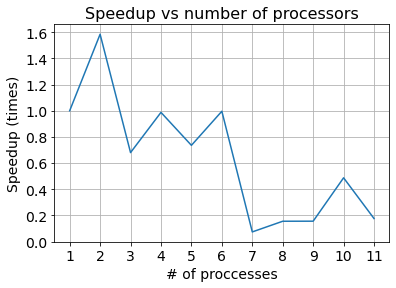

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Speedup vs number of processors', fontsize=16)
plt.plot(times[0] / np.array(times))
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

## Subtask 3: Plot memory consumption vs number of processors

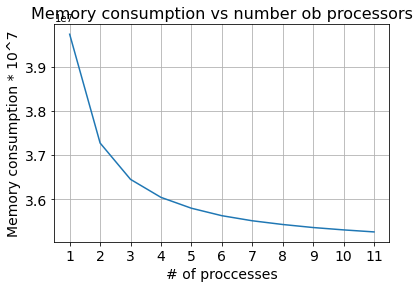

In [8]:
plt.title('Memory consumption vs number ob processors', fontsize=16)
plt.plot(np.array(memoryPeak))
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Memory consumption * 10^7", fontsize=14)
plt.xticks(np.arange(0, len(memoryPeak)), np.arange(1, len(memoryPeak)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

# Task 9 Conway's game of life
## Subtask 1: Implement the game of life sequentially

https://www.conwaylife.com/patterns/gosperglidergun.cells
https://www.conwaylife.com/w/index.php?title=Gosper_glider_gun

alive - 2/3 neighbours
dead -> alive if 3 alive neighbours
periodic grid

### Random filling or Glider filling

In [1]:
%pylab inline
import pygame
from random import randint
from copy import deepcopy
from numba import njit

# the numbers according the colours
white = 0 
black = 2

died = black
empty = black
alive = white

def fillByGlider(W, H):
    GLIDER = np.array(
        [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]])
    padx1, padx2, pady1, pady2 = int((W-39)/2), int((W-39)/2), int((W-9)/2), int((W-9)/2) + 1
    GLIDER = np.pad(GLIDER, ((pady1,pady2),(padx1,padx2)))
    return GLIDER

def fillFieldByRandom(life_cells, W, H):
    life_cells = int(life_cells * W * H)
    current_field = np.ones([W,H]) * 0 # fill current fied with empty cels
    counter1 = life_cells # fill field with black values
    while (counter1): # while not fill all alive cells
        x, y = randint(0, W-1), randint(0, H-1) # choose random cell
        # if this cell is empty
        if current_field[x][y] == 0:
            current_field[x][y] = 1
            counter1 -= 1
    return current_field

def fillByCondition(W, H, condition = 0, life_cells = 1.0):
    if condition == 0: filling = [[1 if not i % 9 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 2,5,8,9,10,11,13,18,21,22,26,30,33,65
    elif condition == 1: filling = [[1 if not (2 * i + j) % 4 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # (2,4),(4,4)
    elif condition == 2: filling = [[1 if not (i * j) % 22 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 5,6,9,22,33
    elif condition == 3: filling = [[1 if not i % 7 else randint(0, 1) for i in range(1,W+1)] for j in range(1,H+1)]
    elif condition == 'glider' or condition == 4: filling = fillByGlider(W, H)
    elif condition == 'random' or condition == 5: filling = fillFieldByRandom(life_cells = life_cells, W = W, H = H)
    filling = np.pad(filling, ((1,1),(1,1)))
    return 2*abs(filling-1)

@njit(fastmath=True)
def check_cells(current_field, next_field, W, H):
    # fill the ghost cells to provide map's periodicity
    current_field[0, 0:H] = current_field[W-2, 0:H]
    current_field[W-1, 0:H] = current_field[1, 0:H]
    current_field[0:W, 0] = current_field[0:W, H-2] 
    current_field[0:W,H-1] = current_field[0:W, 1]
    
    for x in range(1,W+1): # go along x axis except borders
        for y in range(1,H+1): # go along y axis except borders
            
            cell_type = current_field[y][x]
            count = -1 # don't count self
            # around current cell
            for j in range(y-1,y+2):
                for i in range(x-1,x+2):
                    # increase counter if find same cell
                    if current_field[j][i] == cell_type:
                        count += 1
            
            if current_field[y][x] == alive:
                if count == 2 or count == 3:
                    next_field[y][x] = current_field[y][x] # = alive - field won't change
                else:
                    next_field[y][x] = died # cell will die
            
            if current_field[y][x] == died:                
                if count == 5:
                    next_field[y][x] = alive # cell will alive
                else:
                    next_field[y][x] = current_field[y][x] # = died
    return next_field

def gameOfLife(FPS = 10, STOP_counter = 100, CELLS =10, life_cells = 1.0, condition = 'glider'):
    W, H = CELLS, CELLS
    TILE = int(800 / CELLS)
    RES = CELLS * TILE, CELLS * TILE
    FPS = FPS
    
    pygame.init()
    surface = pygame.display.set_mode(RES)
    clock = pygame.time.Clock()

    # fill zero values for all cells (empty cells)
    next_field = np.ones([W+2,H+2]) * died

    # fill current field with black and white agents
    
    current_field = fillByCondition(W = W, H = H, condition = condition, life_cells = life_cells)

    while (STOP_counter):
        STOP_counter -= 1 # decrease counter in each step
        surface.fill(pygame.Color('grey')) # fill yhe game field
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                STOP_counter = 0
                exit()
        
        # put colours into each cell with according with cell's filling (number)
        for x in range(W): # go along x axis
            for y in range(H+1): # go along y axis
                # if number = white then white colour
                if (current_field[x+1][y+1] == white):
                    pygame.draw.rect(surface, pygame.Color('white'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))
                # if number = black then black colour
                if (current_field[x+1][y+1] == black):
                    pygame.draw.rect(surface, pygame.Color('black'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))
        # calculate the next field filling
        next_field = check_cells(current_field, next_field, W = W, H = H)
        
        if np.array_equal(current_field,next_field):
            STOP_counter = 0
                    
        # consider current field as the next field (it'll be previous field in the next step)
        current_field = deepcopy(next_field)
        # print(clock.get_fps())
        pygame.display.flip()
        clock.tick(FPS)
    exit()

gameOfLife(FPS = 30, STOP_counter = 25000, CELLS = 51 ,life_cells = 0.1, condition = 5)

Populating the interactive namespace from numpy and matplotlib
pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Subtask 2: Provide a parallel implementation

## Subtask 3: Your parallel implementation runs for any number of MPI processors, regardless of the number of cells

## Subtask 4: Run the game with the "Gosper's glider gun" initial condition

## Subtask 5: Model at least two more initial conditions
### Creating initial fields (6 variants)

In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import h5py

def fillByGlider(W, H):
    GLIDER = np.array(
        [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
        [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]])
    padx1, padx2, pady1, pady2 = int((W-39)/2), int((W-39)/2), int((W-9)/2), int((W-9)/2) + 1
    GLIDER = np.pad(GLIDER, ((pady1,pady2),(padx1,padx2)))
    return GLIDER

def fillFieldByRandom(life_cells, W, H):
    life_cells = int(life_cells * W * H)
    current_field = np.ones([W,H]) * 0 # fill current fied with empty cels
    counter1 = life_cells # fill field with black values
    while (counter1): # while not fill all alive cells
        x, y = randint(0, W-1), randint(0, H-1) # choose random cell
        # if this cell is empty
        if current_field[x][y] == 0:
            current_field[x][y] = 1
            counter1 -= 1
    return current_field

def fillByCondition(W, H, condition = 0, life_cells = 0.5):
    if condition == 0: filling = [[1 if not i % 9 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 2,5,8,9,10,11,13,18,21,22,26,30,33,65
    elif condition == 1: filling = [[1 if not (2 * i + j) % 4 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # (2,4),(4,4)
    elif condition == 2: filling = [[1 if not (i * j) % 22 else 0 for i in range(1,W+1)] for j in range(1,H+1)] # 5,6,9,22,33
    elif condition == 3: filling = [[1 if not i % 7 else randint(0, 1) for i in range(1,W+1)] for j in range(1,H+1)]
    elif condition == 'glider' or condition == 4: filling = fillByGlider(W, H)
    elif condition == 'random' or condition == 5: filling = fillFieldByRandom(life_cells = life_cells, W = W, H = H)
    filling = np.pad(filling, ((1,1),(1,1)))
    return filling

def create_fields(W, H, life_cells):
    for i in range(0,6):
        initial_field = fillByCondition(W, H, condition = i, life_cells = life_cells)

        # ghost cells
        initial_field[0, 0:H+2] = initial_field[W, 0:H+2]
        initial_field[W+1, 1:H+2] = initial_field[1, 1:H+2]
        initial_field[0:W+2, 0] = initial_field[0:W+2, H] 
        initial_field[0:W+2,H+1] = initial_field[0:W+2, 1]

        with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'w') as f:
            f.create_dataset('init_array_0', data = initial_field)
  
def show_fields():
    for i in range(0,6):
        with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'r') as f:
            data_set = f['init_array_0'][:]

        plt.figure(figsize=(5, 5))
        plt.imshow(data_set)
        plt.show

def choose_grid(i):
    with h5py.File('Test/Initial_grid_'+str(i)+'.hdf5', 'r') as f:
                data = f['init_array_0'][:]

    with h5py.File('Test/Next_grid.hdf5', 'w') as f:
                f.create_dataset('array_0', data = data)
    plt.figure(figsize=(5, 5))
    plt.title('Сhosen grid', fontsize=16)
    plt.imshow(data)

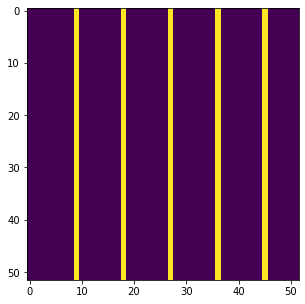

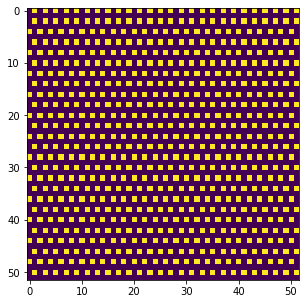

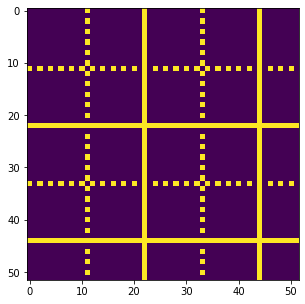

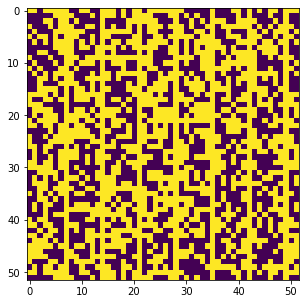

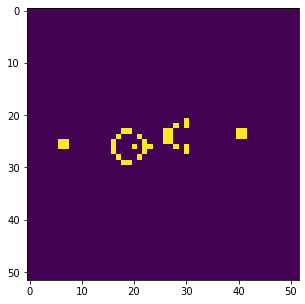

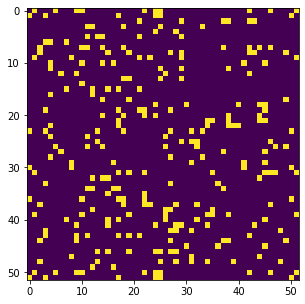

In [2]:
show_fields()

In [6]:
%%writefile gameoflife.py
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numba import njit
import argparse

parser = argparse.ArgumentParser('gameoflife')
parser.add_argument('-f', type = int, default = 0, help='frame')
flag = parser.parse_args()
flag = flag.f

comm = MPI.COMM_WORLD
n_proc = comm.Get_size()
rank = comm.Get_rank()

with h5py.File('Test/Next_grid.hdf5', 'r') as f:
    previous_field = f['array_0'][:]
    f.close()

W, H = previous_field.shape[0] - 2, previous_field.shape[1] - 2
w, h = previous_field.shape[0], previous_field.shape[1]

living_cells = np.sum(previous_field[1:w-1,1:h-1] == 1)

assert n_proc <= W, 'The number of processes lower than cells in current dimension'
X_size = W // n_proc

# def fillfield_part(field_size_y, field_size_x):
#     field_part = np.zeros([field_size_y, field_size_x])
#     field_part = np.random.randint(0, 2, (field_size_y, field_size_x))
#     field_part = np.pad(field_part, ((1,1),(1,1)))
#     return field_part

#@njit(fastmath=True)
def parallel_processing(current_field, next_field):
    alive = 1
    died = 0
    #next_field = deepcopy(current_field)
    W_loc, H_loc = current_field.shape[0], current_field.shape[1]    

    for x in range(1,H_loc-1): # go along x axis except borders
        for y in range(1,W_loc-1): # go along y axis except borders
            
            cell_type = current_field[y][x]
            count = -1 # don't count self
            # around current cell
            for j in range(y-1,y+2):
                for i in range(x-1,x+2):
                    # increase counter if find same cell
                    if current_field[j][i] == cell_type:
                        count += 1
            
            if current_field[y][x] == alive:
                if count == 2 or count == 3:
                    next_field[y][x] = current_field[y][x] # = alive - field won't change
                else:
                    next_field[y][x] = died # cell will die
            
            if current_field[y][x] == died:                
                if count == 5:
                    next_field[y][x] = alive # cell will alive
                else:
                    next_field[y][x] = current_field[y][x] # = died
                    
    return next_field

add_last = 0
if rank == n_proc - 1:
    if W % n_proc == 0:
        add_last = 0
    else:
        add_last = W % n_proc


# positions accorded to the ghost cells
start_x = X_size * rank
end_x = X_size * (rank + 1) + 2 + add_last

data = parallel_processing(previous_field[:,start_x:end_x], deepcopy(previous_field[:,start_x:end_x]))
data = comm.gather(data, root=0)

# if zero process =>
if rank == 0:
    out = [] # out array
    # for each process
    for i in range(n_proc):
        # cut the perimeter (ghost cells) and append into out[]
        a = data[i][1:data[i].shape[0]-1,1:data[i].shape[1]-1]
        out.append(a)
    out = np.concatenate((out), axis=1) # concatenate out array
    
    out = np.pad(out, ((1,1),(1,1))) # add padding

    # add ghost cells
    out[0, 0:H+2] = out[W, 0:H+2]
    out[W+1, 1:H+2] = out[1, 1:H+2]
    out[0:W+2, 0] = out[0:W+2, H] 
    out[0:W+2,H+1] = out[0:W+2, 1]
    with h5py.File('Test/Next_grid.hdf5', 'w') as f:
        f.create_dataset('array_0', data = out)
        f.close()

    plt.figure(figsize=(5, 5))
    plt.title('living_cells = ' + str(living_cells), fontsize=16)
    plt.imshow(out)
    #plt.savefig('Test/Game/Cond_0/Cond_0-'+str(flag))
    #plt.savefig('Test/Game/Cond_1/Cond_1-'+str(flag))
    plt.savefig('Test/Game/Cond_2/Cond_2-'+str(flag))
    #plt.savefig('Test/Game/Cond_3/Cond_3-'+str(flag))
    #plt.savefig('Test/Game/Cond_4/Cond_4-'+str(flag))
    #plt.savefig('Test/Game/Cond_5/Cond_5-'+str(flag))
    plt.close()
    print(living_cells)

Overwriting gameoflife.py


In [ ]:
import subprocess
condition = 4
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 350
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

## Subtask 6: Plot the number of the living cells vs time for the three initial conditions above

In [ ]:
import subprocess
condition = 4
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 350
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

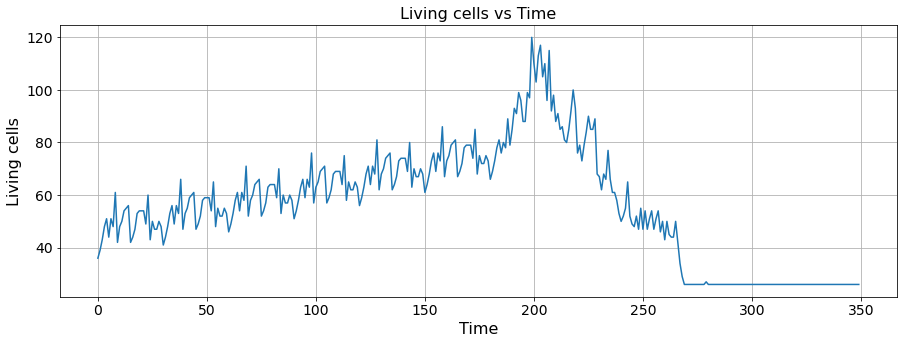

In [11]:
condition = 4
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])

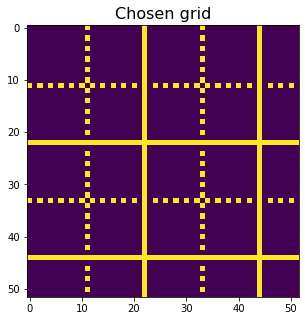

In [7]:
import subprocess
condition = 2
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 100
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

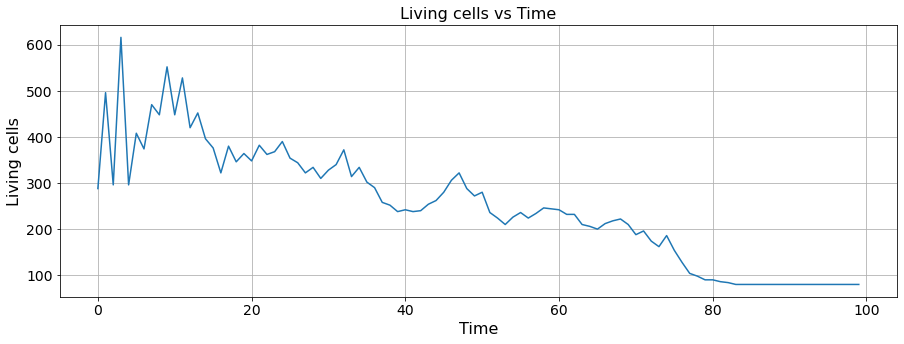

In [10]:
condition = 2
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])

In [ ]:
import subprocess
condition = 0
create_fields(W = 50, H = 50, life_cells = 0.1) # life_cells only for 5th condition
choose_grid(condition)

n_proc = 1
n_frames = 350
living = []
for i in range(0, n_frames, 1):
    a = subprocess.run(["mpiexec","-n", str(n_proc),"python", "gameoflife.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    living.append(res[0])
    
living = list(map(float, living))
living

np.savez('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition), living = living)

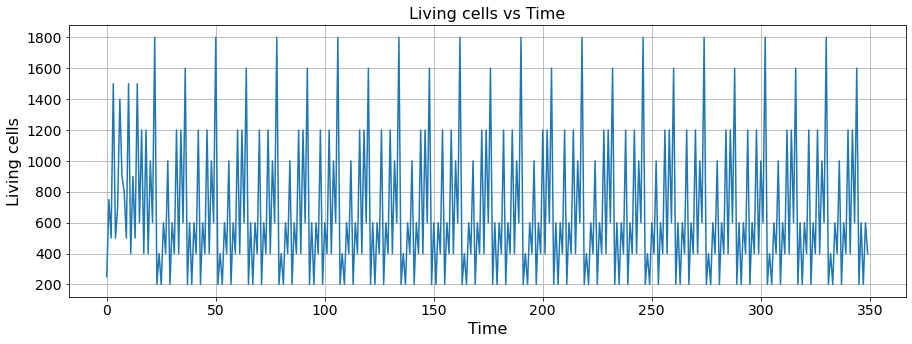

In [9]:
condition = 0
ex = np.load('Test/Game/Cond_'+str(condition)+'/Living_'+str(condition)+'.npz')
plt.figure(figsize=(15, 5))
plt.title('Living cells vs Time', fontsize=16)
plt.ylabel('Living cells', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(ex['living'])

# Task 10
## Subtask 1: an explanation of the difference between cupu and numpy. How does cupy handle data transfers  between cpu and gpu?

In [14]:
import cupy as cp

ModuleNotFoundError: No module named 'cupy'

In [13]:
import cupy as cp
import numpy as np

In [16]:
cp.cuda.Device()

<CUDA Device 0>

CuPy has a concept of the current device, which is the default device on which the allocation, manipulation, calculation etc. of arrays are taken place. 

CuPy -GPU, Numpy - CPU

cupy.asarray() can be used to move a numpy.ndarray, a list, or any object that can be passed to numpy.array() to the current device (GPU).

In [14]:
x_cpu = np.array([1, 2, 3])
x_gpu = cp.asarray(x_cpu)  # move the data to the current device.

Moving a device array to the host can be done by cupy.asnumpy():

In [15]:
x_gpu = cp.array([1, 2, 3])  # create an array in the current device
x_cpu = cp.asnumpy(x_gpu)  # move the array to the host.

We can also use cupy.ndarray.get():

In [11]:
x_cpu = x_gpu.get()

## Subtask 2: Function saxpy that runs on GPU using cupu is provied

In [2]:
import cupy as cp
import numpy as np

def np_saxpy(x, y, a):
    return x*a + y

@cp.fuse()
def cp_saxpy(x, y, a):
    return x*a + y

## Subtask 3: Graph - computation time vs size of arrays (for numpy and cupy)

In [40]:
np_results = []
for size in np.logspace(1, 4, 20):
    size = int(size)
    np_x = np.random.rand(size, size).astype(np.float32)
    np_y = np.random.rand(size, size).astype(np.float32)
    np_a = np.float32(5.0)
    t = %timeit -o -q np_saxpy(np_x, np_y, np_a);
    np_results.append(t)

In [41]:
np_results

[<TimeitResult : 1.5 µs ± 36.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 <TimeitResult : 1.53 µs ± 14.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 <TimeitResult : 1.78 µs ± 56.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 <TimeitResult : 2.05 µs ± 43.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 <TimeitResult : 2.39 µs ± 6.28 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 <TimeitResult : 3.17 µs ± 9.12 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 <TimeitResult : 4.61 µs ± 81.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 <TimeitResult : 8 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 <TimeitResult : 15.6 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 <TimeitResult : 30.9 µs ± 65 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 62.3 µs ± 3.27 µs per loop (mean ± std. dev. of 

In [42]:
cp_results = []
for size in cp.logspace(1, 4, 20):
    size = int(size)
    cp_x = cp.random.rand(size, size).astype(cp.float32)
    cp_y = cp.random.rand(size, size).astype(cp.float32)
    cp_a = cp.float32(2.0)
    t = %timeit -o -q np_saxpy(cp_x, cp_y, cp_a);
    cp_results.append(t)

In [43]:
cp_results

[<TimeitResult : 22.6 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 24.1 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 22.2 µs ± 89.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 22.1 µs ± 250 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 22.2 µs ± 706 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 21.7 µs ± 239 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 21.8 µs ± 522 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 21.8 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 21.9 µs ± 379 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 21.8 µs ± 52.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 <TimeitResult : 30.8 µs ± 725 ns per loop (mean ± std. dev. of 7 runs, 1000

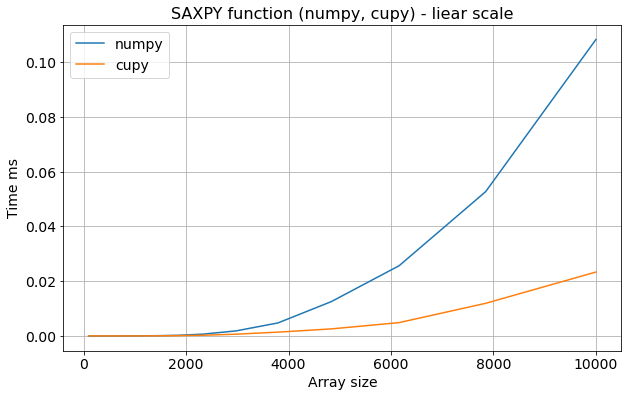

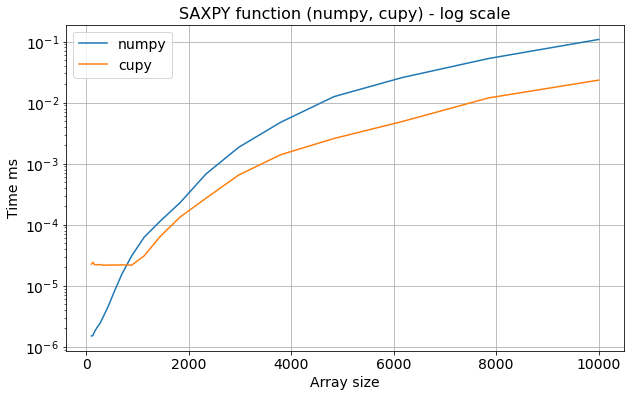

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(np.logspace(2, 4, 20), [i.average for i in np_results])
plt.plot(np.logspace(2, 4, 20), [i.average for i in cp_results])
plt.title('SAXPY function (numpy, cupy) - liear scale', fontsize=16)
#plt.yscale('log')
plt.xlabel('Array size', fontsize=14)
plt.ylabel('Time ms', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['numpy', 'cupy'], fontsize=14);
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.logspace(2, 4, 20), [i.average for i in np_results])
plt.plot(np.logspace(2, 4, 20), [i.average for i in cp_results])
plt.title('SAXPY function (numpy, cupy) - log scale', fontsize=16)
plt.yscale('log')
plt.xlabel('Array size', fontsize=14)
plt.ylabel('Time ms', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['numpy', 'cupy'], fontsize=14);
plt.grid()
plt.show()

# Task 11
## Subtask 1: Bifurcation map using cupy arrays

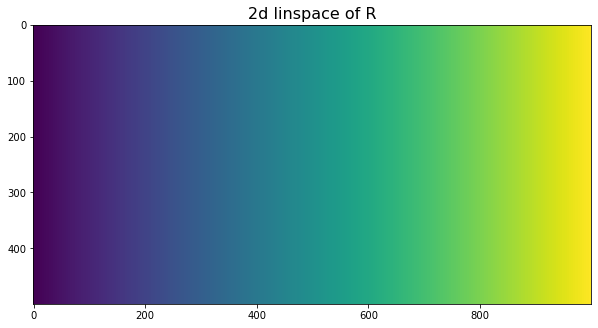

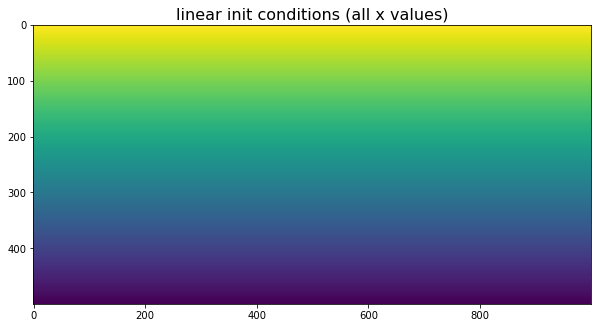

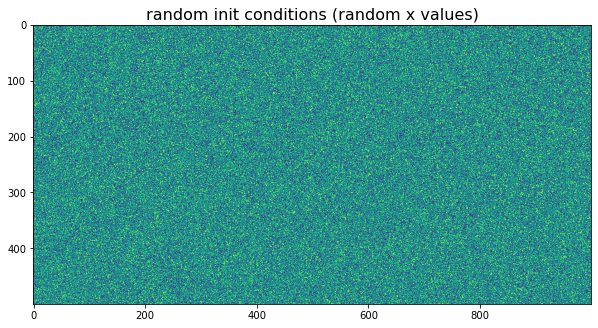

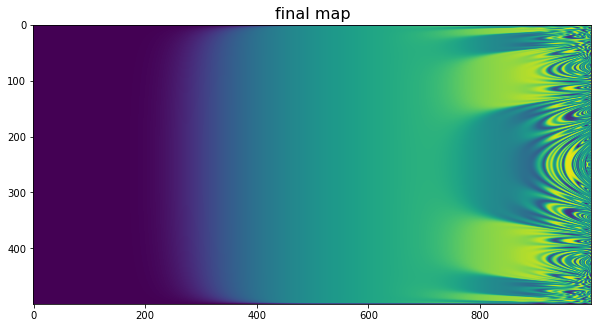

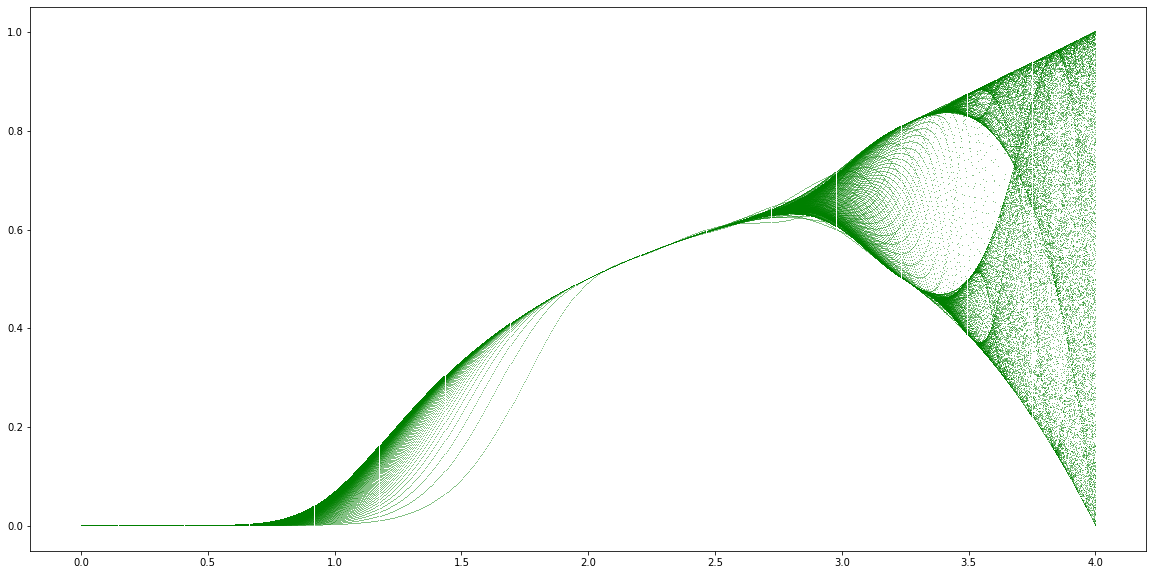

In [3]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda

def CuPu_bifurcationShow(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 1000, plot = True):

    def cudaa(init, maxiter):
        for i in range(maxiter):
            init = init * linspaceR_2d * (1 - init)
        return init
    
    # creating 2d linspace of R:
    multiplier = cp.ones([points_y,1])
    linspaceR_1d = cp.linspace(start_r, end_r, points_r).reshape([1,points_r])
    linspaceR_2d = multiplier @ linspaceR_1d
    plt.figure(figsize=(10, 10))
    plt.title('2d linspace of R', fontsize=16)
    plt.imshow(linspaceR_2d.get())
    plt.show()
    
    # init conditions (all values of x or absolutely random)
    init_conditions1 = cp.random.rand(linspaceR_2d.shape[0], linspaceR_2d.shape[1])
    init_conditions =  cp.linspace(1, 0, points_y).reshape([points_y,1]) @ cp.ones([1,points_r])
    plt.figure(figsize=(10, 10))
    plt.title('linear init conditions (all x values)', fontsize=16)
    plt.imshow(init_conditions.get())
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('random init conditions (random x values)', fontsize=16)  
    plt.imshow(init_conditions1.get())
    plt.show()
    
    # recursive algorithm
    init = init_conditions
    init = cudaa(init, maxiter)
    plt.figure(figsize=(10, 10))
    plt.title('final map', fontsize=16) 
    plt.imshow(init.get())
    plt.show()
    
    if plot == True:
        fig = plt.figure(figsize=(20, 10))
        for j in range (1):
            plt.plot(linspaceR_2d[1:499,0:].get(), init[1:499,0:].get(),',',color ='g',alpha=.28)
        plt.close()
        return fig
    else:
        return None
    
CuPu_bifurcationShow(points_r = 1000, points_y = 500, start_r = 0, end_r = 4, maxiter = 10, plot = True)

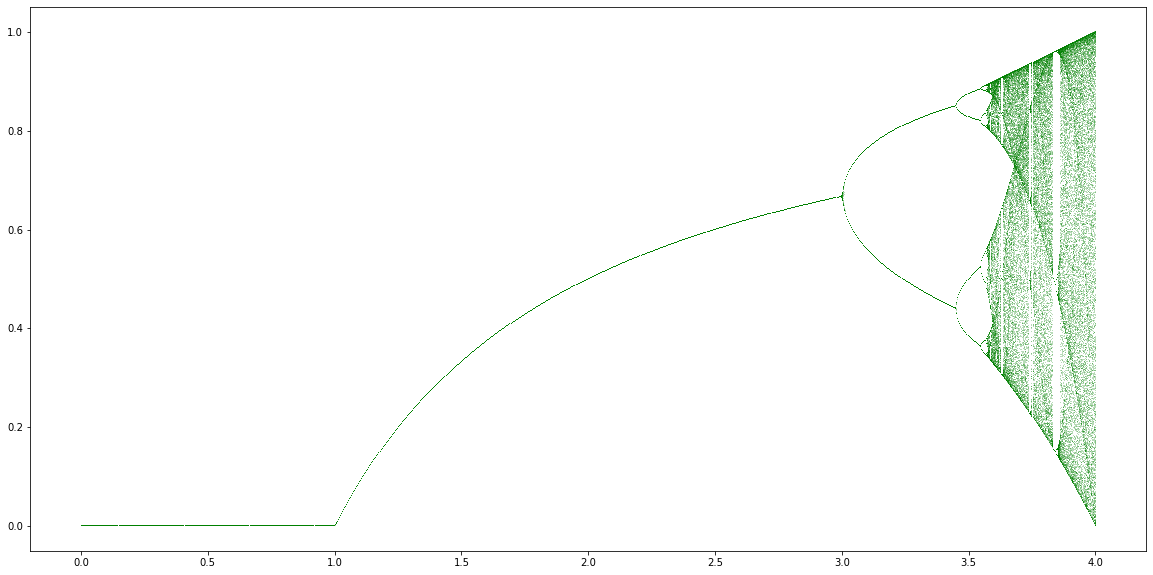

In [4]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda


def CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 1000, plot = True):

    def cudaa(init, maxiter):
        for i in range(maxiter):
            init = init * linspaceR_2d * (1 - init)
        return init
    
    # creating 2d linspace of R:
    multiplier = cp.ones([points_y,1])
    linspaceR_1d = cp.linspace(start_r, end_r, points_r).reshape([1,points_r])
    linspaceR_2d = multiplier @ linspaceR_1d
    # plt.imshow(linspaceR_2d.get())
    
    # init conditions (all values of x or absolutely random)
    # init_conditions = cp.random.rand(linspaceR_2d.shape[0], linspaceR_2d.shape[1])
    init_conditions =  cp.linspace(1, 0, points_y).reshape([points_y,1]) @ cp.ones([1,points_r])
    # plt.imshow(init_conditions.get())

    
    # recursive algorithm
    init = init_conditions
    init = cudaa(init, maxiter)
    # plt.imshow(init.get())
    
    if plot == True:
        fig = plt.figure(figsize=(20, 10))
        for j in range (1):
            plt.plot(linspaceR_2d[1:499,0:].get(), init[1:499,0:].get(),',',color ='g',alpha=.28)
        plt.close()
        return fig
    else:
        return None
    
CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 500, plot = True)

## Subtask 2: Bifurcation map using cupy arrays is profiled

In [20]:
%load_ext snakeviz
%snakeviz CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 300, plot = False)

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/tmp/tmpqezzxlxh'. 
Embedding SnakeViz in this document...


In [3]:
%prun -r CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 300, plot = False)

         938 function calls in 0.012 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.010    0.010    0.012    0.012 <ipython-input-1-abf086809fdf>:5(CuPu_bifurcation)
        2    0.001    0.000    0.001    0.000 ranges.py:61(_linspace_scalar)
      302    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(min_scalar_type)
        2    0.000    0.000    0.000    0.000 {method 'fill' of 'cupy.core.core.ndarray' objects}
        2    0.000    0.000    0.000    0.000 basic.py:134(ones)
        1    0.000    0.000    0.012    0.012 {built-in method builtins.exec}
      300    0.000    0.000    0.000    0.000 multiarray.py:583(min_scalar_type)
        2    0.000    0.000    0.001    0.000 ranges.py:114(linspace)
        2    0.000    0.000    0.000    0.000 {method 'reshape' of 'cupy

## Subtask 3: Graph - computation time vs number of total iterations (CPU, MPI, CuPy implementations)

Populating the interactive namespace from numpy and matplotlib


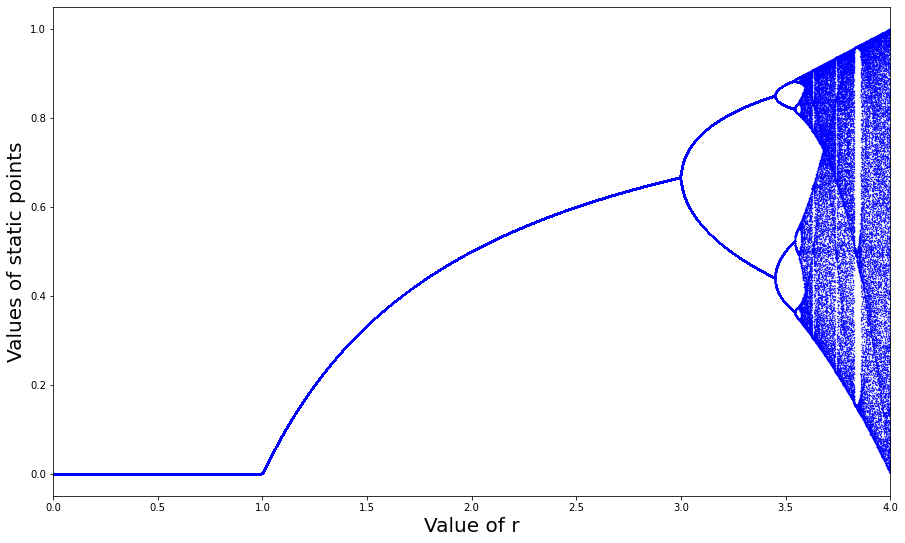

In [7]:
%pylab inline
from numba import njit

#@njit(fastmath=True)
def func(pointsX = 1000, minX = 0, maxX = 4, m = 10, steps = 100):
    r = np.linspace(minX, maxX, pointsX) # the range of r

    X = np.zeros((pointsX, m)) # array for scatterplot
    Y = np.zeros((pointsX, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in arange(pointsX):
        x[0] = np.random.rand() # random initial value
        for n in range(1,steps):
            # choose 1 option
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            # x[n] = r[j] * sin(x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot

    return X, Y

def plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500, plot = True):
    X, Y = func(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500)
    if plot == True:
        fig = plt.figure(figsize=(15, 9))
        xlim((minX, maxX))   # set the xlim to left, right
        #ylim(0, 1)     # set the xlim to left, right
        plt.ylabel('Values of static points', fontsize=20)
        plt.xlabel('Value of r', fontsize=20)
        plt.scatter(Y,X, c = 'b', s = 0.1)
        plt.close()
        return fig
    else:
        return None

plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500, plot = True)

In [5]:
%%writefile bifurcation.py

import matplotlib.pyplot as plt

from mpi4py import MPI
import math
import numpy as np
import argparse

parser = argparse.ArgumentParser('gameoflife')
parser.add_argument('-f', type = int, default = 0, help='frame')
flag = parser.parse_args()
flag = flag.f

def count(proc, points_X = 1000, n_proc = 10, minX = 0, maxX = 4, steps = 1000, m = 30):
    block_X = int(points_X / n_proc) # integer blocks of x axis
    remainder = points_X % n_proc # remainder for the last block

    add = 0 # addition of the last block
    if proc == n_proc-1: # if current process is last
        add = remainder # addition is equal to remainder
    
    # current x array (last with add =/= 0)
    arrayX = np.arange(block_X * proc, block_X * (proc+1) + add, 1)
    
    r = np.linspace((proc) * maxX / n_proc, (proc + 1) * maxX / n_proc, arrayX.size)
    # print(arrayX.size)
    
    X = np.zeros((block_X, m)) # array for scatterplot
    Y = np.zeros((block_X, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in range(0, block_X, 1):
        x[0] = np.random.rand()
        
        for n in range(1,steps):
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
    return X, Y

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    print('nprocs = ', n_proc)
    t0 = MPI.Wtime() # measure start time
  

X,Y = count(proc = rank, points_X = 10000, n_proc = n_proc, minX = 0, maxX = 4, steps = flag, m = 20)

X, Y = comm.gather(X, root=0), comm.gather(Y, root=0)

if rank == 0:
    fig = plt.scatter(Y,X, c = 'b', s = 0.1)
    totalTime = MPI.Wtime() - t0
    print('',np.round((totalTime),4) * 1000, 'mSec')
    np.savez('Task_1/example_'+str(n_proc), totalTime = np.round((totalTime),4) * 1000)
    
    #plt.figure(figsize=(15, 9))
    #plt.xlim((0, 4))   # set the xlim to left, right
    #plt.ylim(0, 1)     # set the xlim to left, right
    #plt.title('Bifurcation diagram', fontsize=14)
    #plt.ylabel('Values of static points', fontsize=14)
    #plt.xlabel('Value of r', fontsize=14)
    #plt.savefig('Task_1/BIF1', dpi = 200)
    #plt.close()

Overwriting bifurcation.py


nprocs =  4
 720.5 mSec


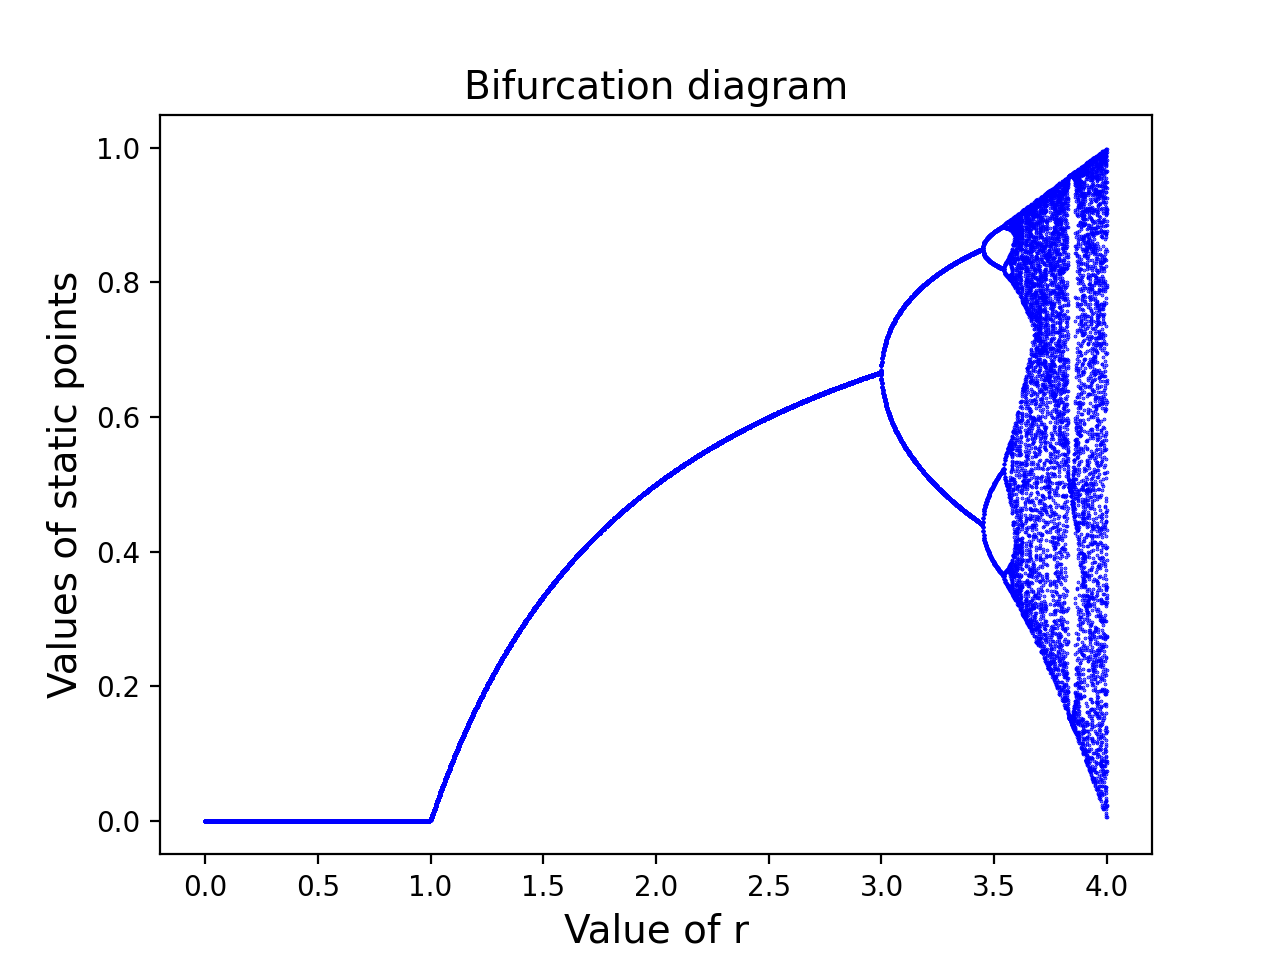

In [6]:
!mpirun -n 4 python bifurcation.py -f 300
from IPython.display import Image
Image("Task_1/BIF1.png")

In [8]:
CuPy = []
for i in range(30, 300, 20):
    t = %timeit -o -q CuPu_bifurcation(points_r = 10000, points_y = 500, start_r = 0, end_r = 4, maxiter = i, plot = False)
    CuPy.append(t)

In [9]:
CPU = []
for i in range(30, 300, 20):
    t = %timeit -o -q plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = i, plot = False)
    CPU.append(t)

In [10]:
import subprocess

MPI = []
for i in range(30, 300, 20):
    a = subprocess.run(["mpirun","-n", str(4),"python", "bifurcation.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    MPI.append(res[4])
    
MPI = list(map(float, MPI))

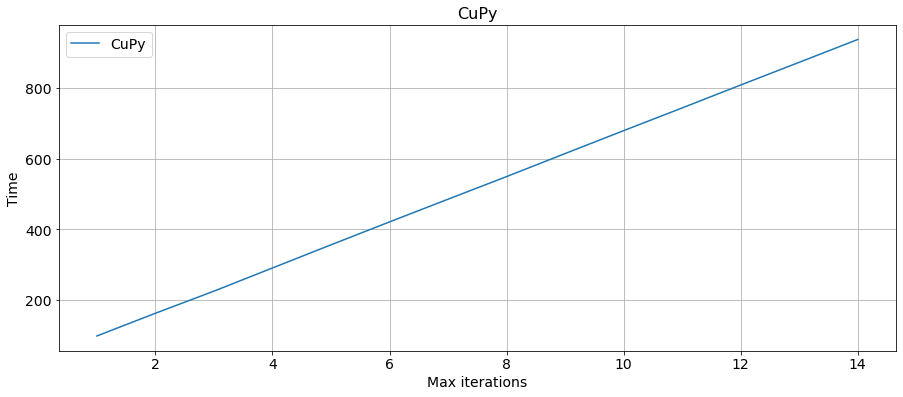

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000 * i.average for i in CuPy])
#plt.plot(np.arange(1, len(CPU)+1, 1), [i.average for i in CPU])
#plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('CuPy', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy'], fontsize=14);
plt.grid()
plt.show()

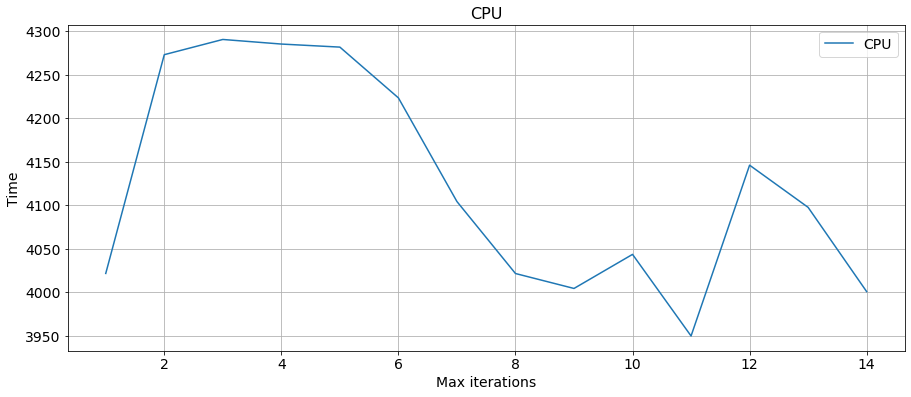

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
#plt.plot(np.arange(1, len(CuPy)+1, 1), [i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000 * i.average for i in CPU])
#plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('CPU', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CPU'], fontsize=14);
plt.grid()
plt.show()

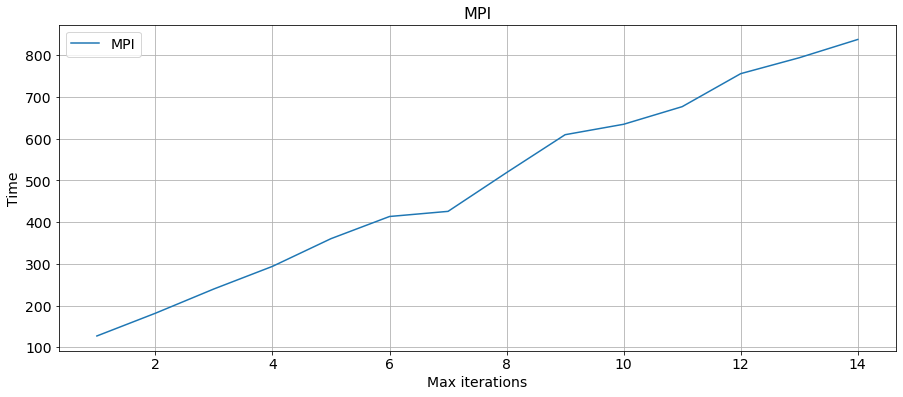

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
#plt.plot(np.arange(1, len(CuPy)+1, 1), [i.average for i in CuPy])
#plt.plot(np.arange(1, len(CPU)+1, 1), [i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['MPI'], fontsize=14);
plt.grid()
plt.show()

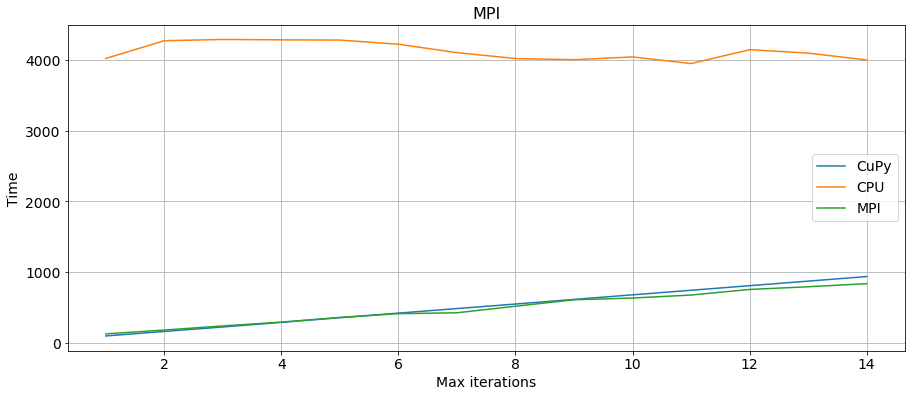

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000*i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000*i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy','CPU','MPI'], fontsize=14);
plt.grid()
plt.show()

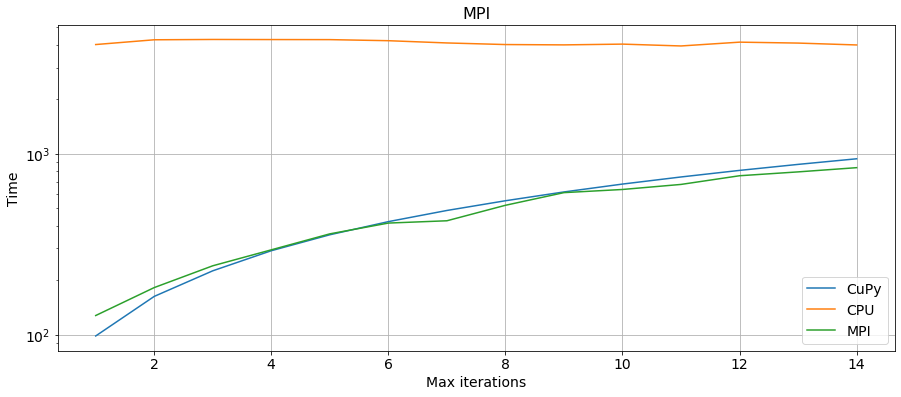

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000*i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000*i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy','CPU','MPI'], fontsize=14);
plt.grid()
plt.show()

# Task 12 (Histogram)
## Subtask 1: Function from the Jupiter notebook is plotted with suggested number of points

In [23]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

@cp.fuse()
def f(x):
    return (cp.power(z(x),2) + cp.power(z(x),3) - 200 * cp.power(z(x),4)) * cp.sin(1e5 * (x + 0.5))

@cp.fuse()
def z(x):
    return cp.sin(3 * x) - 0.5

start, end = 0, 1
points = 10**7
x = cp.linspace(start, end, points)
y = f(x)
f_min = y.min()
f_max = y.max()
delta = 0.1 * (f_max - f_min)

print('Min: {}. Max {}.'.format(f_min, f_max))

Min: -12.365544666168107. Max 12.374912294071224.


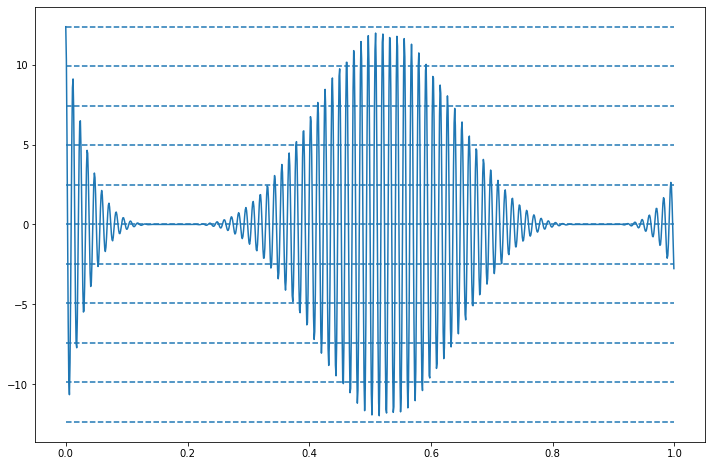

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(x.get()[::10000], y.get()[::10000]) # take each 10000th point to plot
plt.hlines([np.float(f_min + i * delta) for i in range(11)], 0, 1, linestyles='--')

## Subtask 2: Histogram is ploted

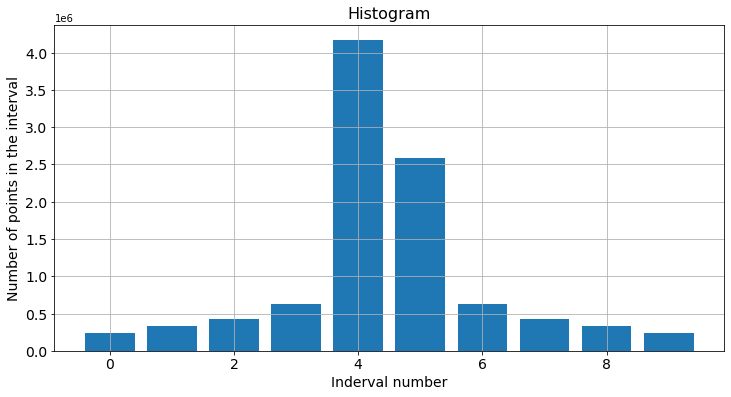

In [26]:
points_list = []
for i in range(10):
    in_points = ((f_min + (i+1)*delta) > y) & (y > (f_min + i*delta)) #
    in_points = cp.sum(in_points)
    in_points = cp.asnumpy(in_points)
    points_list.append(in_points)
points_list = np.array(points_list)

plt.figure(figsize=(12, 6))
plt.bar(np.arange(10),points_list)
plt.title('Histogram', fontsize=16)
plt.xlabel('Inderval number', fontsize=14)
plt.ylabel('Number of points in the interval', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

## Subtask 3: Computation time of cp.sum() and np.sum() are provided (just functions without graph)

In [28]:
i = 1
cp_in_points = ((f_min + (i+1)*delta) > y) & (y > (f_min + i*delta))
np_in_points = cp.asnumpy(cp_in_points)

In [29]:
%timeit -n 100 cp.sum(cp_in_points)

16.3 µs ± 5.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit -n 100 np.sum(np_in_points)

7.17 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Task 13
## Subtask 1: Before and after pictures are given (100*100 img)

In [3]:
import numpy as np 
import cupy as cp 
from matplotlib import pyplot as plt
from PIL import Image

size = 300 # image size
k = int(size / 100)
path = "img/image1.jpg"
image = np.array(Image.open(path).resize((size, size)).convert('L')) # open image an np.array
cmap = 'gray' # colour map
 
# kernel parameters
k_border = 2 * k
k_size = 2 * k_border + 1

# cupy and numpy kernels
np_kernel = np.ones((k_size,k_size)) # square kernel for numpy
np_kernel /= np_kernel.sum() # values normalization
cp_kernel = cp.array(np_kernel) # same kernel as for numpy, but for cupy

In [4]:
np_kernel.shape

(13, 13)

In [5]:
# blur function (input parted image, kernel, input array type)
def np_blur(parted_image, kernel):
    kernel = np.ravel(kernel) # squeeze to 1 dimension
    out = np.dot(parted_image, kernel) # multiplication with kernel
    out = np.reshape(out, (size, size)) # reshape into initial size
    return out

def cp_blur(parted_image, kernel):
    kernel = cp.ravel(kernel)
    out = cp.dot(parted_image, kernel)
    out = cp.reshape(out, (size, size))
    return out

def break_image(img):
    np_parted_image = np.zeros((size * size, k_size * k_size), dtype='float32')
    # for all pixels (i,j) exept borders
    for i in range(k_border, size - k_border):
        for j in range(k_border, size - k_border):
            # pack arrays into one dimension
            # consequtevly save each kernel into array size*size, k_size,k_size
            np_parted_image[i * size + j] = img[i - k_border:i + k_border + 1, j - k_border:j + k_border + 1].flatten()
    return np_parted_image

In [6]:
# divide image into parts
np_parted_image = break_image(image)
# same as numpy
cp_parted_image = cp.array(np_parted_image)

# numpy blur
np_blured = np_blur(np_parted_image, kernel = np_kernel)

# cupy blur
cp_blured = cp_blur(cp_parted_image, kernel = cp_kernel)

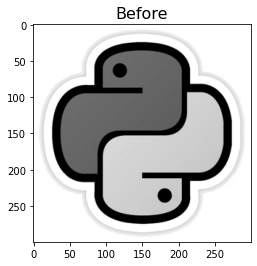

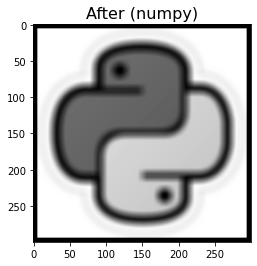

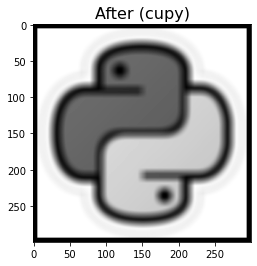

In [7]:
plt.title('Before', fontsize=16)
plt.imshow(image, cmap = cmap)
plt.show()
plt.title('After (numpy)', fontsize=16)
plt.imshow(np_blured.astype(np.uint8), cmap = cmap)
plt.show()
plt.title('After (cupy)', fontsize=16)
plt.imshow(cp.asnumpy(cp_blured).astype(np.uint8), cmap = cmap)
plt.show()

## Subtask 2: Cupy version computation time is given

In [32]:
%timeit -n 10 cp_blur(cp_parted_image, cp_kernel)

42.7 µs ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Subtask 3: Numpy version computation time is given

In [33]:
%timeit -n 10 np_blur(np_parted_image, np_kernel)

45.1 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Task 14
## Subtask 2: Numba is used, Subtask 3: Acceleration using numba achieved
## my implementation With JIT

Populating the interactive namespace from numpy and matplotlib


/home/stas/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


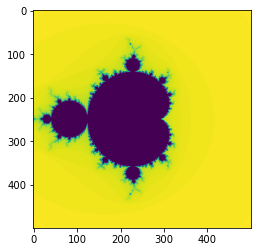

In [8]:
%pylab inline
from numba import njit
import seaborn as sns

@njit(fastmath=True)
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
    fig = plt.figure(figsize=(14, 11))
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )   
    # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    plt.close(fig)

    return image
    
image = juliaSetRainbow(size = 1.5, pixels = 500, max_iterations = 100, infinity_border = 2)
plt.imshow(image)

# my implementation Without JIT

In [3]:
%pylab inline
from numba import njit
import seaborn as sns

#@njit(fastmath=True)
def count(size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size
    pointsRe, pointsIm = pixels, pixels
    max_iterations = max_iterations
    infinity_border = infinity_border
    
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = 0
            c = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    return image

def juliaSetRainbow(size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300):
    
    image = np.rot90(count(size, pixels, max_iterations, infinity_border))
#     fig = plt.figure(figsize=(14, 11))
#     sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
#                 # cbar_kws= {'orientation': 'vertical'}
#                )   
#     # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
#     plt.ylabel('Imaginary(z_inf)', fontsize=20)
#     plt.xlabel('Real(z_inf)', fontsize=20)
#     plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
#     plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
#     plt.close(fig)

    return image
    
%timeit image = juliaSetRainbow(size = 1.5, pixels = 500, max_iterations = 100, infinity_border = 2)
# plt.imshow(image)

Populating the interactive namespace from numpy and matplotlib
994 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### shared implementation With JIT

In [5]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

%timeit image = create_image()

# plt.imshow(image)

24.6 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# shared implementation Without JIT

In [4]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import njit

#@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

%timeit image = create_image()

# plt.imshow(image)

1.74 s ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Shared code profiling

## Subtask 1: Mandelbrot code is profiled

In [49]:
#%%writefile mandelbrot.py
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image():
    image = np.zeros((500, 500), dtype=np.uint8)
    s = timer()
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 100)
    e = timer()
    # print(e - s)
    return image

image = create_image()
#plt.imshow(image)

In [39]:
%load_ext snakeviz
%snakeviz create_image()

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
 
*** Profile stats marshalled to file '/tmp/tmp0s593rwd'. 
Embedding SnakeViz in this document...


## Subtask 4: Measuring computation time - number of total iterations vs computational time (JITed, regular)
### Without JIT

In [7]:
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

#@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

#@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

451.2831389999974 mSec
616.3075650001701 mSec
762.4729920000846 mSec
916.6810870001427 mSec
1049.316120999947 mSec
1208.1071299999167 mSec
1353.006526999934 mSec
1480.3156390000822 mSec
1624.9566630001482 mSec
1762.0144170000458 mSec
1896.3926220001213 mSec
2047.620889999962 mSec
2171.190420999892 mSec
2307.3229450001236 mSec
2699.9634960000094 mSec
2553.5822090000693 mSec
2728.9742999998907 mSec
2823.165248999885 mSec
2964.144400000123 mSec
3161.04572800009 mSec
3408.0239329998676 mSec
3441.3747090000015 mSec
3605.3399370000534 mSec
3661.2365840001075 mSec
4208.473200999833 mSec
3963.27475399994 mSec
4264.771174000089 mSec
4426.981552999905 mSec
4479.634037000096 mSec


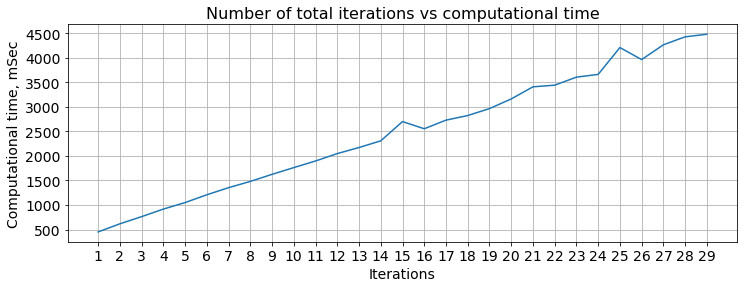

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

### With JIT

In [47]:
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import njit

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

@njit
def create_image(max_iters):
    image = np.zeros((500, 500), dtype=np.uint8)
    image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, iters = max_iters)
    return image

times = []
for max_iters in range(10, 300,10):
    s = 0
    s = timer()
    image = create_image(max_iters = max_iters)
    e = timer()
    time = (e - s)*1000
    print(time, 'mSec')
    times.append(time)

237.6898490001622 mSec
6.753779000064242 mSec
9.196633000101428 mSec
11.29582199973811 mSec
14.28192799903627 mSec
16.222972999457852 mSec
18.453192000379204 mSec
20.375586000227486 mSec
22.290556000370998 mSec
24.97778000179096 mSec
26.874177001445787 mSec
28.96490300008736 mSec
31.423551999978372 mSec
33.31884200088098 mSec
34.93145100037509 mSec
37.05048700066982 mSec
38.94359600053576 mSec
43.196409998927265 mSec
43.1902109994553 mSec
45.604839999214164 mSec
47.736468999573844 mSec
53.44777100071951 mSec
53.93940800058772 mSec
55.17826700088335 mSec
56.95420499978354 mSec
56.37214300077176 mSec
59.2447799990623 mSec
60.4677269984677 mSec
62.35369699970761 mSec


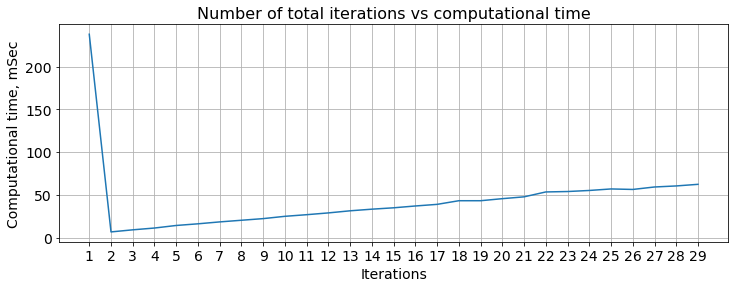

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.title('Number of total iterations vs computational time', fontsize=16)
plt.plot(times)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Computational time, mSec", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()